In [21]:
! pip install keras-rl2
! pip install chess
! pip install python-chess

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,\
     Input,BatchNormalization, Dropout, Conv2D, Add, Reshape
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

import chess
import chess.engine
from sys import platform
import os

# from bot_model.model888 import get_model888

import tensorflow as tf
tf.compat.v1.experimental.output_all_intermediates(True)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2021-12-24 17:45:56.169892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-24 17:45:56.169982: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13838064870066430219
]


2021-12-24 17:46:01.634136: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-24 17:46:01.638724: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-24 17:46:01.638785: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-24 17:46:01.639014: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LoG): /proc/driver/nvidia/version does not exist


In [23]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from drive.MyDrive.Data.Chess.model888 import get_model888

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4430433725400181736
]


2021-12-23 23:00:53.411448: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# %%
os.system('chmod +x drive/MyDrive/Data/Chess/stockfish_14.1_linux_x64')
engine = chess.engine.SimpleEngine.popen_uci(r"drive/MyDrive/Data/Chess/stockfish_14.1_linux_x64")


In [2]:
# # %%
# if platform == "linux" or platform == "linux2":
#     os.system('chmod +x ../stockfish/stockfish_14.1_linux_x64')
#     engine = chess.engine.SimpleEngine.popen_uci(r"../stockfish/stockfish_14.1_linux_x64")
# elif platform == "win32":
#     engine = chess.engine.SimpleEngine.popen_uci(r"../stockfish/stockfish_14.1_win_32bit.exe")

In [3]:
def find_move(env):
    result = engine.play(env.env, chess.engine.Limit(time=0.05))
    return result.move

In [4]:
STATE_SHAPE = (8, 8, 8)
NB_ACTIONS = 4096

In [5]:
def convert(x,square,map):
    for i in range(8):
        for j in range(8):
            if square[i][j]==map:
                x[i][j]=1
            elif square[i][j] == -map:
                x[i][j]=-1   
                 

In [6]:
class ChessEnv:
    '''
    state - obser: ndarray - (65,): [:65] is flatten from int_board; [65] is color of bot; 1 is white and -1 is black
    step: int. step_range = (0, 4096) , is encoded from square A to square B (64 x 64 val)
    reward: int
    '''

    mapped = {
            'P': 10,     # White Pawn
            'p': -10,    # Black Pawn
            'N': 20,     # White Knight
            'n': -20,    # Black Knight
            'B': 30,     # White Bishop
            'b': -30,    # Black Bishop
            'R': 40,     # White Rook
            'r': -40,    # Black Rook
            'Q': 50,     # White Queen
            'q': -50,    # Black Queen
            'K': 900,     # White King
            'k': -900     # Black King
    }
    point=[10,20,30,40,50,900]
    state = None
    model = None
    neg_r_each_step = -1
    
    def __init__(self, model: Sequential, neg_r_each_step = -1) -> None:
        self.env = chess.Board()
        self.model = model
        self.lastest_move=[0,0]
        self.state = self.reset()
        self.neg_r_each_step = neg_r_each_step

    def is_draw(self):
        if self.env.is_stalemate():
            print("statlemate")
            return True
        if self.env.is_fivefold_repetition():
            print("fivefold repetition")
            return True
        if self.env.is_seventyfive_moves():
            print("75 moves")
            return True
        if self.env.is_insufficient_material():
            print("Insufficient Material")
            return True
        return False

    def is_checkmate(self):
        # If There is checkmate then it will be TRUE else FALSE.It will be a boolean value.
        return self.env.is_checkmate()

    def convert_board_to_int(self):
        epd_string = self.env.epd()
        list_int = np.empty((0, ))
        for i in epd_string:
            if i == " ":
                list_int = list_int.reshape((8, 8))
                return list_int
            elif i != "/":
                if i in self.mapped:
                    list_int = np.append(list_int, self.mapped[i])
                else:
                    for counter in range(0, int(i)):
                        list_int = np.append(list_int, 0)
        list_int = list_int.reshape((8, 8))
        return list_int

    def get_state(self) -> np.ndarray:
        square=self.convert_board_to_int()
        x=np.zeros([8,8,8])
        for i in range(6):
            convert(x[i],square,self.point[i])
        moves=self.legal_moves()
        for move in moves:
            a= move.from_square
            b= move.to_square
            x[6][7-int(a /8)][a%8]=-1
            x[6][7-int(b /8)][b%8]=1
        a=self.lastest_move[0]
        b=self.lastest_move[1]
        if a!=b:
            x[7][7-a //8][a%8]=-1
            x[7][7-b//8][b%8] =1   
        else: 
            x[7]=[[0]*8 for i in range(8)]
        return x   
        

    def legal_moves(self):
        return list(self.env.legal_moves)

    def encodeMove(self, move_uci:str):
        a, b = chess.parse_square(move_uci[:2]), chess.parse_square(move_uci[2:])
        return a * 64 + b

    def decodeMove(self, move_int:int):
        a, b = move_int//64, move_int%64
        move = self.env.find_move(from_square= a,to_square= b)
        return move

    def render(self):
        print(self.env.unicode())

    def reset(self):
        # random state
        redo = True
        num_sample_steps = 0
        while redo:
            redo = False
            self.env = chess.Board()
            num_sample_steps = np.random.randint(0, 15)
            for i in range (num_sample_steps):
                lg_move = self.legal_moves()
                if len(lg_move) != 0:
                    move = np.random.choice(self.legal_moves())
                    self.env.push(move)
                else:
                    redo = True
                    break
        if len(self.env.move_stack) !=0:
            self.lastest_move[0]= self.env.move_stack[-1].from_square
            self.lastest_move[1]= self.env.move_stack[-1].to_square
        else:
            self.lastest_move[0]=0
            self.lastest_move[1]=0
        if self.env.turn == False:
            self.env=self.env.mirror() 
            for i in range(2):
                a=7-self.lastest_move[i]//8
                b=self.lastest_move[i]%8
                self.lastest_move[i]=8*a+b

        self.state =  self.get_state()

        Q_val = self.model.predict(self.state.reshape((1, 1) + STATE_SHAPE)).reshape(-1, )
        print('Val:', min(Q_val), max(Q_val))
        return self.state

    def step(self, action: int):
        reward = 0
        done = True
        
        try:
            # move in legal move
            move = self.decodeMove(action)
        except:
            # wrong move
            reward = -5000
            done = True
            print('wrong_move')
            return self.state, reward, done, {}

        # neg reward each step
        reward = self.neg_r_each_step

        # location to_square
        to_r, to_c = 7 - move.to_square//8, move.to_square%8
        try:
            reward += self.point[np.where(self.state[:6, to_r, to_c ] != 0)[0][0]]
        except:
            reward += 0

        # action
        self.env.push(move)

        #convert turn
        self.lastest_move[0]= self.env.move_stack[-1].from_square
        self.lastest_move[1]= self.env.move_stack[-1].to_square
        self.env=self.env.mirror() 
        for i in range(2):
            a=7-self.lastest_move[i]//8
            b=self.lastest_move[i]%8
            self.lastest_move[i]=8*a+b

        self.state = self.get_state()

        # check end game
        if self.is_checkmate():
            reward += 900
            done = True
            print('Win')
        elif self.is_draw():
            reward += 300
            done = True

        # opponent's turn   
        else:
            done = False

            move = find_move(self)

            # location to_square
            to_r, to_c = 7 - move.to_square//8, move.to_square%8
            try:
                reward -= self.point[np.where(self.state[:6, to_r, to_c ] != 0)[0][0]]
            except:
                reward -= 0

            # action
            self.env.push(move)

            #convert turn
            self.lastest_move[0]= self.env.move_stack[-1].from_square
            self.lastest_move[1]= self.env.move_stack[-1].to_square 
            self.env=self.env.mirror() 
            for i in range(2):
                a=7-self.lastest_move[i]//8
                b=self.lastest_move[i]%8
                self.lastest_move[i]=8*a+b

            self.state = self.get_state()

            # check end game
            if self.is_checkmate():
                reward -= 900
                done = True
                print('Lose')
            elif self.is_draw():
                reward += 300
                done = True

        

        return self.state, reward, done, {}


In [7]:
# model
model = get_model888(STATE_SHAPE, NB_ACTIONS)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 8, 8, 8)] 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 8, 8, 8)      0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 12, 12, 8)    0           reshape[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 12, 12, 64)   32832       zero_padding2d[0][0]             
______________________

In [8]:
env = ChessEnv(model, neg_r_each_step=-1)

/home/kienanh/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-12-24 17:46:26.216141: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz
2021-12-24 17:46:27.589974: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16384000 exceeds 10% of free system memory.


Val: -0.0020264278 0.0020372416


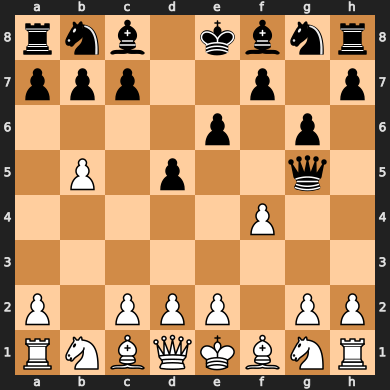

In [10]:
env.env

In [9]:
#NOTE
# model.load_weights('superbot_888.h5')
model.load_weights('drive/MyDrive/Data/Chess/superbot_888.h5')


OSError: Unable to open file (unable to open file: name = 'drive/MyDrive/Data/Chess/superbot_888.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# # Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# # even the metrics!
memory = SequentialMemory(limit=10000, window_length=1)
for i in range (10):
  policy = EpsGreedyQPolicy(0.3)
  dqn = DQNAgent(model=model, nb_actions=NB_ACTIONS, memory=memory, batch_size = 16,
                target_model_update=1e-2, policy=policy, nb_steps_warmup = 500)
  dqn.compile(Adam(lr=1e1), metrics=['mae'])

  his = dqn.fit(env, nb_steps=7500, visualize=False, verbose=2)
  
  #NOTE
  model.save('superbot_888.h5')
  !cp -r superbot_888.h5 /content/drive/MyDrive/Data/Chess


/home/kienanh/.local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/home/kienanh/.local/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Training for 50000 steps ...
wrong_move
     1/50000: episode: 1, duration: 1.852s, episode steps:   1, steps per second:   1, episode reward: -5000.000, mean reward: -5000.000 [-5000.000, -5000.000], mean action: 2929.000 [2929.000, 2929.000],  loss: --, mae: --, mean_q: --
wrong_move
     2/50000: episode: 2, duration: 0.030s, episode steps:   1, steps per second:  33, episode reward: -5000.000, mean reward: -5000.000 [-5000.000, -5000.000], mean action: 2929.000 [2929.000, 2929.000],  loss: --, mae: --, mean_q: --
wrong_move
     3/50000: episode: 3, duration: 0.036s, episode steps:   1, steps per second:  28, episode reward: -5000.000, mean reward: -5000.000 [-5000.000, -5000.000], mean action: 2929.000 [2929.000, 2929.000],  loss: --, mae: --, mean_q: --
wrong_move
     4/50000: episode: 4, duration: 0.030s, episode steps:   1, steps per second:  33, episode reward: -5000.000, mean reward: -5000.000 [-5000.000, -5000.000], mean action: 2929.000 [2929.000, 2929.000],  loss: --, mae

/home/kienanh/.local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    11/50000: episode: 11, duration: 15.675s, episode steps:   1, steps per second:   0, episode reward: -5000.000, mean reward: -5000.000 [-5000.000, -5000.000], mean action: 2929.000 [2929.000, 2929.000],  loss: --, mae: --, mean_q: --
wrong_move
    12/50000: episode: 12, duration: 1.629s, episode steps:   1, steps per second:   1, episode reward: -5000.000, mean reward: -5000.000 [-5000.000, -5000.000], mean action: 0.000 [0.000, 0.000],  loss: 12400056.000000, mae: 1.237822, mean_q: 0.034309
wrong_move
    13/50000: episode: 13, duration: 1.657s, episode steps:   1, steps per second:   1, episode reward: -5000.000, mean reward: -5000.000 [-5000.000, -5000.000], mean action: 0.000 [0.000, 0.000],  loss: 12234706.000000, mae: 1.242155, mean_q: 0.034309
wrong_move
    14/50000: episode: 14, duration: 1.882s, episode steps:   1, steps per second:   1, episode reward: -5000.000, mean reward: -5000.000 [-5000.000, -5000.000], mean action: 3333.000 [3333.000, 3333.000],  loss: 12080092.0

/home/kienanh/.local/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
